The FastText model was introduced by Facebook in 2016 as an extension and supposedly
improvement of the vanilla Word2Vec model

It’s based on the original paper entitled
“Enriching Word Vectors with Subword Information” by Mikolov et al.,

Overall,
FastText is a framework for learning word representations and performing robust, fast,
and accurate text classifications

In general, predictive
models like Word2Vec consider each word a distinct entity (e.g., where) and generate
a dense embedding for the word

The FastText model considers each word a Bag of Character n-grams. This is also called a
subword model in the paper


We add special boundary symbols < and > at the beginning and end of words. This
enables us to distinguish prefixes and suffixes from other character sequences

We also
include the letter w in the set of its n-grams to learn a representation for each word

In practice, the paper recommends extracting all the n-grams for n ≥ 3 and n ≤ 6.

In [5]:
# Applying FastText Features to Machine Learning Tasks

In [11]:
import numpy as np
import nltk
import re
import spacy
import pandas as pd
import matplotlib.pyplot as plt
from nltk.corpus import gutenberg
from string import punctuation
from keras.preprocessing import text, sequence
from keras.utils import np_utils
from gensim.models import word2vec
from sklearn.cluster import KMeans

In [12]:
wpt = nltk.WordPunctTokenizer()
stop_words = nltk.corpus.stopwords.words('english')
corpus = ['The sky is blue and beautiful.',
          'Love this blue and beautiful sky!',
          'The quick brown fox jumps over the lazy dog.',
          "A king's breakfast has sausages, ham, bacon, eggs, toast and beans",
          'I love green eggs, ham, sausages and bacon!',
          'The brown fox is quick and the blue dog is lazy!',
          'The sky is very blue and the sky is very beautiful today',
          'The dog is lazy but the brown fox is quick!'    
]
labels = ['weather', 'weather', 'animals', 'food', 'food', 'animals', 'weather', 'animals']

def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = wpt.tokenize(doc)
    # filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

normalize_corpus = np.vectorize(normalize_document)
norm_corpus = normalize_corpus(corpus)

bible = gutenberg.sents('bible-kjv.txt')
remove_terms = punctuation + '0123456789'
norm_bible = [[word.lower() for word in sent if word not in remove_terms] for sent in bible]
norm_bible = [' '.join(tok_sent) for tok_sent in norm_bible]
norm_bible = filter(None, normalize_corpus(norm_bible))
norm_bible = [tok_sent for tok_sent in norm_bible if len(tok_sent.split()) > 2]

corpus = np.array(corpus)
corpus_df = pd.DataFrame({'Document': corpus, 
                          'Category': labels})
corpus_df = corpus_df[['Document', 'Category']]
corpus_df

,Document,Category
0,The sky is blue and beautiful.,weather
1,Love this blue and beautiful sky!,weather
2,The quick brown fox jumps over the lazy dog.,animals
3,"A king's breakfast has sausages, ham, bacon, e...",food
4,"I love green eggs, ham, sausages and bacon!",food
5,The brown fox is quick and the blue dog is lazy!,animals
6,The sky is very blue and the sky is very beaut...,weather
7,The dog is lazy but the brown fox is quick!,animals


In [15]:
from gensim.models.fasttext import FastText

wpt = nltk.WordPunctTokenizer()
tokenized_corpus = [wpt.tokenize(document) for document in norm_bible]

# Set values for various parameters
feature_size = 100    # Word vector dimensionality  
window_context = 50          # Context window size                                                                                    
min_word_count = 5   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words


ft_model = FastText(tokenized_corpus, vector_size=feature_size, window=window_context, min_count=min_word_count,sample=sample, sg=1, epochs=50)

In [16]:
# view similar words based on gensim's model
similar_words = {search_term: [item[0] for item in ft_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['god', 'jesus', 'noah', 'egypt', 'john', 'gospel', 'moses','famine']}
similar_words

{'god': ['lord', 'therefore', 'unto', 'us', 'jesus'],
 'jesus': ['christ', 'faith', 'god', 'disciples', 'believe'],
 'noah': ['methuselah', 'milcah', 'flood', 'creepeth', 'shem'],
 'egypt': ['land', 'egyptians', 'pharaoh', 'israel', 'assyria'],
 'john': ['baptist', 'peter', 'baptize', 'philip', 'baptized'],
 'gospel': ['preached', 'christ', 'preach', 'preaching', 'grace'],
 'moses': ['aaron', 'commanded', 'congregation', 'spake', 'israel'],
 'famine': ['pestilence', 'sword', 'dearth', 'land', 'egypt']}

Having these embeddings, we can perform some interesting natural language tasks.
One of these is to determine the similarity between different words (entities)

In [17]:
# One of these is to determine the similarity between different words (entities)

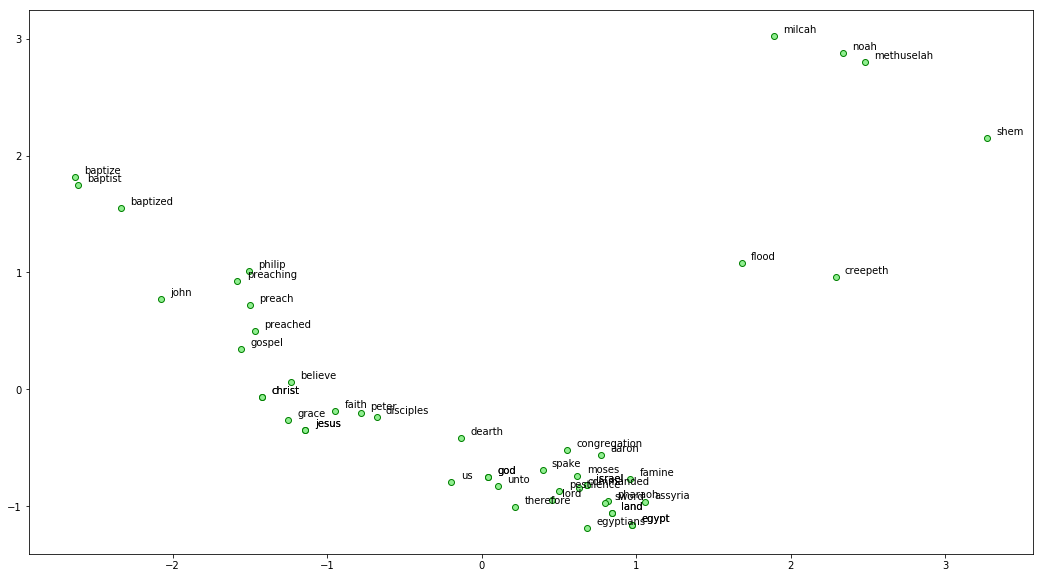

In [18]:
from sklearn.decomposition import PCA

words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = ft_model.wv[words]

pca = PCA(n_components=2)
np.set_printoptions(suppress=True)
P = pca.fit_transform(wvs)
labels = words

plt.figure(figsize=(18, 10))
plt.scatter(P[:, 0], P[:, 1], c='lightgreen', edgecolors='g')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    plt.annotate(label, xy=(x+0.06, y+0.03), xytext=(0, 0), textcoords='offset points')

In [19]:
ft_model.wv['jesus']

array([-0.2618292 , -0.08459348, -0.5464207 , -0.19912924,  0.03717578,
        0.294772  ,  0.13956395,  0.11149478,  0.4180499 , -0.3969794 ,
       -0.1820278 ,  0.22175178, -0.28373057,  0.22762388, -0.27567515,
       -0.38373998,  0.04815359, -0.18119492, -0.00416245,  0.07339428,
       -0.3982486 , -0.02662823, -0.15873075,  0.1827621 , -0.23638868,
       -0.2963389 ,  0.2185062 ,  0.40002984,  0.02804024,  0.66815037,
        0.08437434, -0.10458484,  0.11618526,  0.2575703 ,  0.48358276,
        0.20359723, -0.10058744,  0.490575  ,  0.14859238, -0.13222523,
        0.22295924, -0.24498524,  0.43117765,  0.03844945,  0.30411854,
        0.30329037, -0.04550278, -0.21960872,  0.39428082, -0.08099257,
        0.13417499, -0.1046    ,  0.08671127, -0.25810683, -0.20844643,
       -0.00356634, -0.03084614, -0.20078796, -0.41488823, -0.32240182,
        0.33185732, -0.05614794, -0.000735  ,  0.0002232 ,  0.57857734,
        0.38403   , -0.2919418 ,  0.06128101, -0.25139886, -0.03

In [20]:
print(ft_model.wv.similarity(w1='god', w2='satan'))
print(ft_model.wv.similarity(w1='god', w2='jesus'))

0.30489495
0.6522168


In [21]:
st1 = "god jesus satan john"
print('Odd one out for [',st1, ']:', ft_model.wv.doesnt_match(st1.split()))

st2 = "john peter james judas"
print('Odd one out for [',st2, ']:', ft_model.wv.doesnt_match(st2.split()))

Odd one out for [ god jesus satan john ]: satan
Odd one out for [ john peter james judas ]: judas
